In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

In [21]:
bbX = pd.read_csv('bbDF-q2.csv')
bbX = bbX.loc[:, bbX.columns != 'date']
bbX = bbX.loc[:, bbX.columns != 'Unnamed: 0']
bbX = bbX.loc[:, bbX.columns != 'daychange']
bbX = bbX.loc[:, bbX.columns != 'anger']
bbX = bbX.loc[:, bbX.columns != 'disgust']
bbX = bbX.loc[:, bbX.columns != 'fear']
bbX = bbX.loc[:, bbX.columns != 'joy']
bbX = bbX.loc[:, bbX.columns != 'sadness']
bbX = bbX.loc[:, bbX.columns != 'surprise']
bbX = bbX.loc[:, bbX.columns != 'connectivity']
bbX = bbX.loc[:, bbX.columns != 'avgdeg']
#bbX = bbX.loc[:, bbX.columns != 'clustering']


bbX['clustering'][0] = 0.001
bbX['clustering'][43] = 0.002
bbX = bbX.head(70)
bbX

C:\Users\Danny Verdear\AppData\Local\Temp\ipykernel_3876\4139939437.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbX['clustering'][43] = 0.002


,size,edges,diameter,clustering,volume
0,33,29,6,0.001,11139200
1,23,18,4,0.000,9108900
2,31,23,4,0.000,11022300
3,30,25,4,0.000,13062800
4,51,45,4,0.000,23039300
...,...,...,...,...,...
65,114,94,8,0.000,11406800
66,119,102,10,0.000,6685200
67,172,144,5,0.000,6501800
68,145,136,7,0.000,6896000


In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
sns.set(rc={'figure.figsize':(11,8)})

bbXs = scaler.fit_transform(bbX)
bbXs = pd.DataFrame(bbXs,columns=['size','edges','diameter','clustering','volume'])
#bbXs[['clustering','volume']].plot()

In [23]:
for metric in bbXs.columns:
    result = adfuller(bbXs[[metric]])
    print('A-DF of metric',metric,'has p-value of',result[1])
    print()

A-DF of metric size has p-value of 0.00043922420866646583

A-DF of metric edges has p-value of 0.00021467677395281006

A-DF of metric diameter has p-value of 0.08648772018184153

A-DF of metric clustering has p-value of 1.4006985741328416e-15

A-DF of metric volume has p-value of 0.12857855051341366



In [24]:
#build the VAR model
model = VAR(bbXs)
print(model.select_order(5))

bb_model = model.fit(5)

bb_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 22, Nov, 2023
Time:                     13:32:40
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -27.8889
Nobs:                     65.0000    HQIC:                  -30.5218
Log likelihood:           716.570    FPE:                1.26488e-14
AIC:                     -32.2377    Det(Omega_mle):     2.35185e-15
--------------------------------------------------------------------
Results for equation size
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.037047         0.021479            1.725           0.085
L1.size              36.853400         4.812818            7.657           0.000
L1.edges            -35.657846         4.764959           -7.

Text(0, 0.5, 'Volume (0,1)')

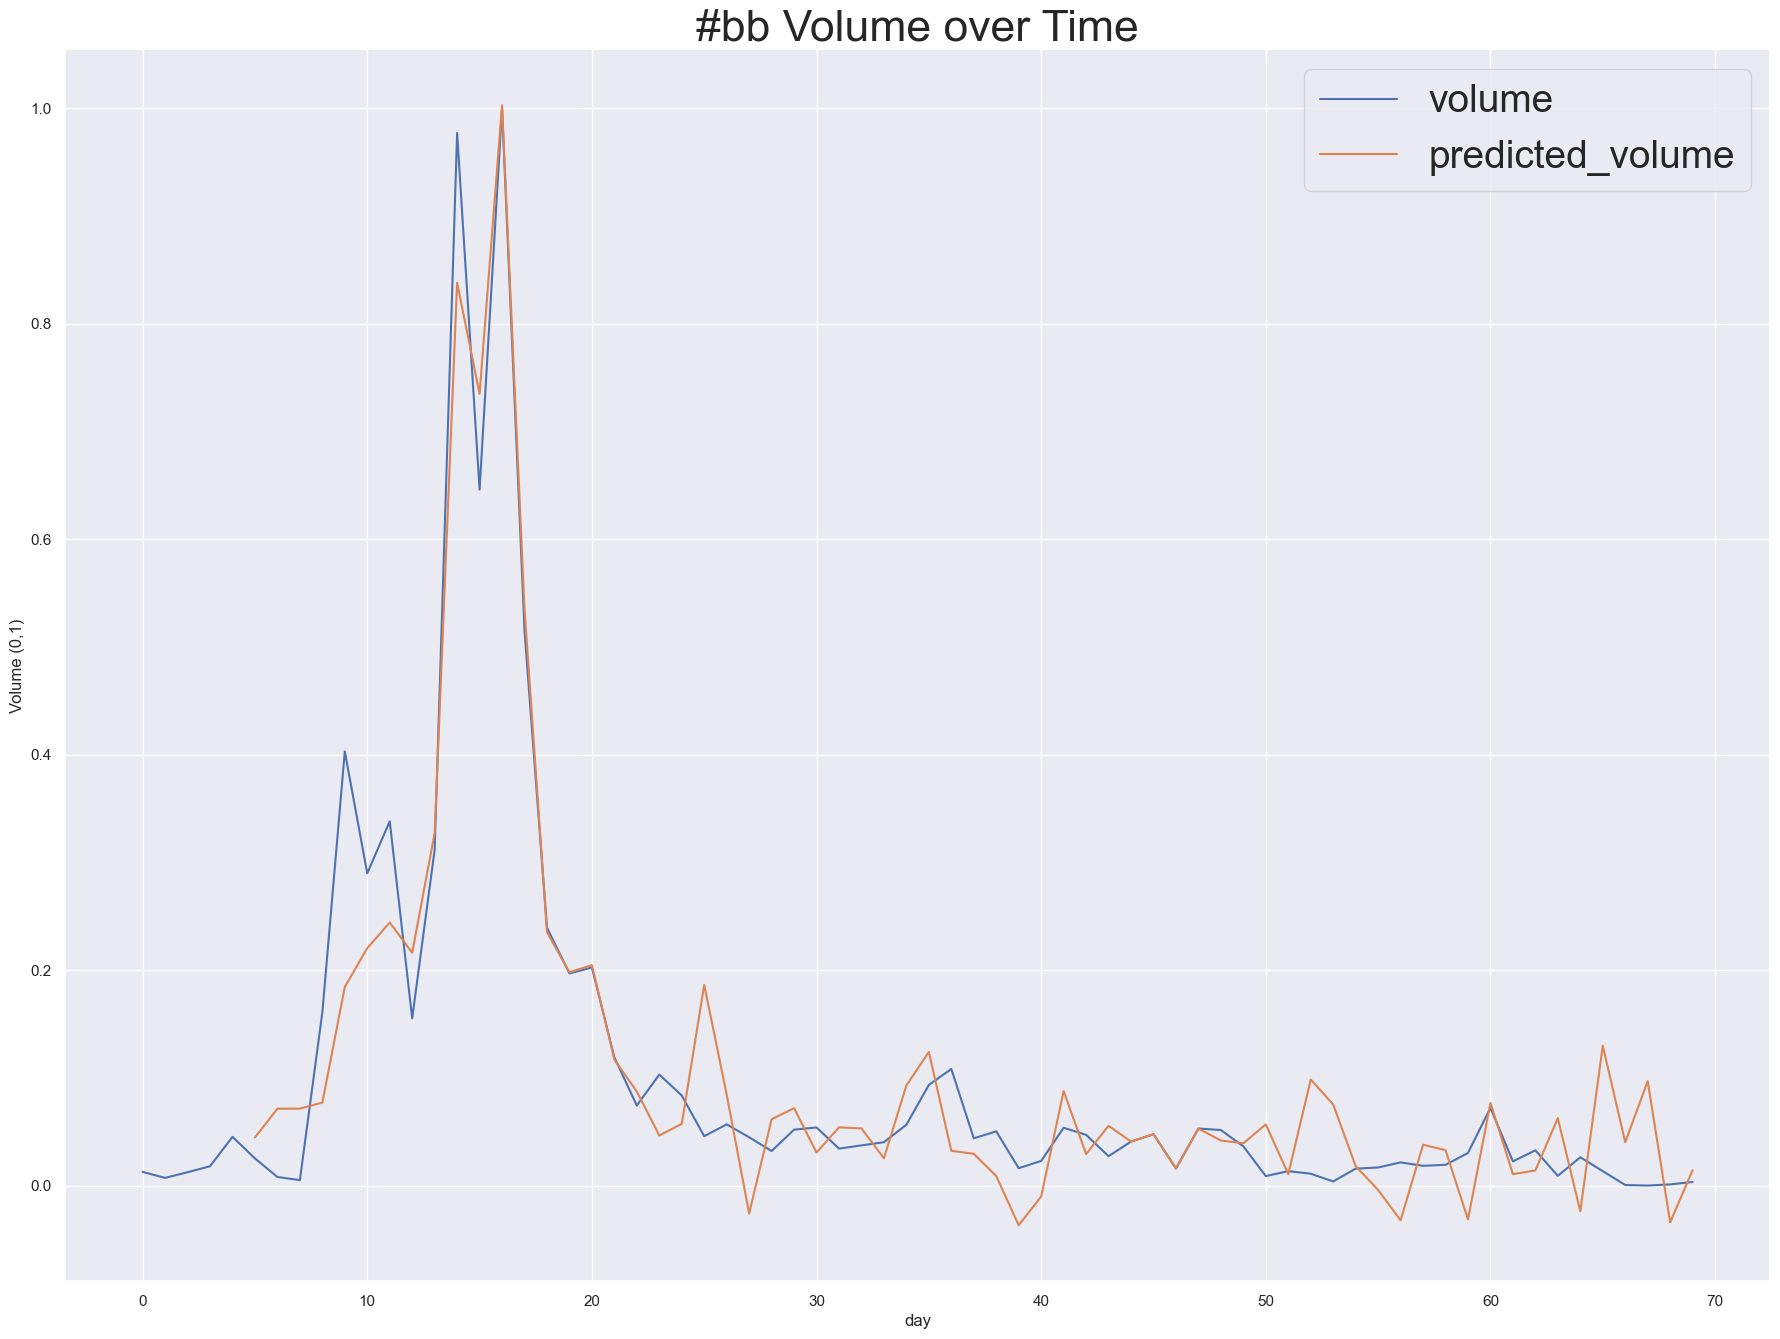

In [25]:
#forecast and plot

sns.set(rc={'figure.figsize':(22,16)})

bbXs[['volume']].plot()
plt.plot(bb_model.fittedvalues['volume'],label='predicted_volume')
plt.legend(fontsize='28')
plt.title('#bb Volume over Time',fontsize=32)
plt.xlabel('day')
plt.ylabel('Volume (0,1)')

In [27]:
#test for causality
print(bb_model.test_causality(4,0))
print(bb_model.test_causality(4,1))
print(bb_model.test_causality(4,2))
print(bb_model.test_causality(4,3))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: size does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 1.614, critical value: 2.260>, p-value: 0.158>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: edges does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 1.382, critical value: 2.260>, p-value: 0.233>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: diameter does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 1.423, critical value: 2.260>, p-value: 0.218>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: clustering does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 0.395, critical value: 2.260>, p-value: 0.852>


In [13]:
print('bb',mean_absolute_error(bbXs[['volume']][5:],bb_model.fittedvalues['volume']))

bb 0.042792368247669764
